In [1]:
import os
import torch
import cv2 as cv
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn as nn
import matplotlib.pyplot as plt
from keras_preprocessing.image import img_to_array

In [2]:
train_high = "./lol_dataset/our485/high"
train_low = "./lol_dataset/our485/low"

test_high = "./lol_dataset/eval15/high"
test_low = "./lol_dataset/eval15/low"

SIZE = 128

In [3]:
def load_images(path):
    x = []
    image_paths = []
    for imageDir in os.listdir(path):
      img_path = os.path.join(path, imageDir)
      image_paths.append(img_path)
    image_paths.sort()
    for img_path in image_paths:
        img = cv.imread(img_path,1)
        if img is None:
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        x.append(img)

        img1 = cv.flip(img,1)
        x.append(img_to_array(img1))

        img2 = cv.flip(img,-1)
        x.append(img_to_array(img2))

        img3 = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
        x.append(img_to_array(img3))

        img4 = cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE)
        x.append(img_to_array(img4))

    return x

In [4]:
x_train = load_images(train_low)
y_train = load_images(train_high)

x_test = load_images(test_low)
y_test = load_images(test_high)

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

# Keras is channels last, whereas pytorch was channel first
x_train = np.reshape(x_train, (len(x_train), 3, SIZE, SIZE))
y_train = np.reshape(y_train, (len(y_train), 3, SIZE, SIZE))

x_test = np.reshape(x_test, (len(x_test), 3, SIZE, SIZE))
y_test = np.reshape(y_test, (len(y_test), 3, SIZE, SIZE))

2425
2425
75
75


In [5]:
def plot_images(image, ground_truth):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'green', fontsize = 10)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Ground Truth ', color = 'black', fontsize = 10)
    plt.imshow(ground_truth)

    plt.show()

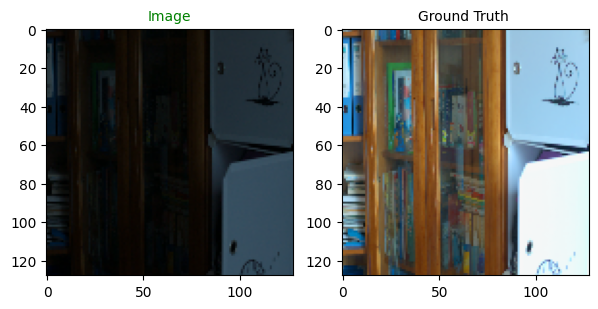

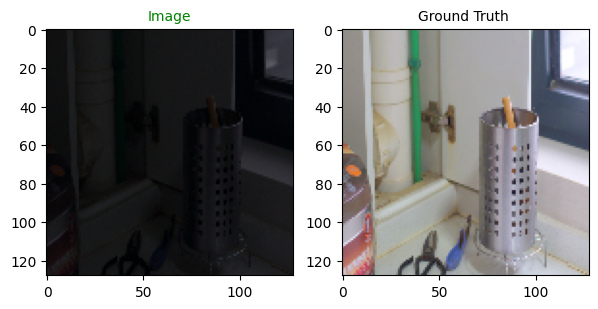

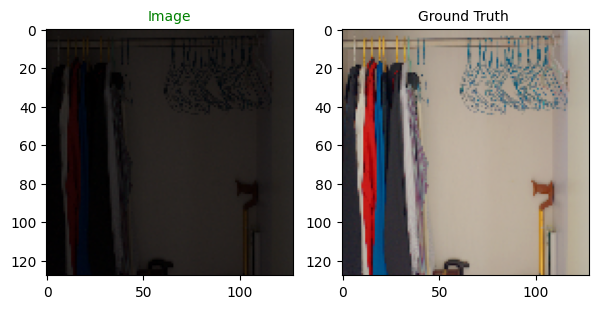

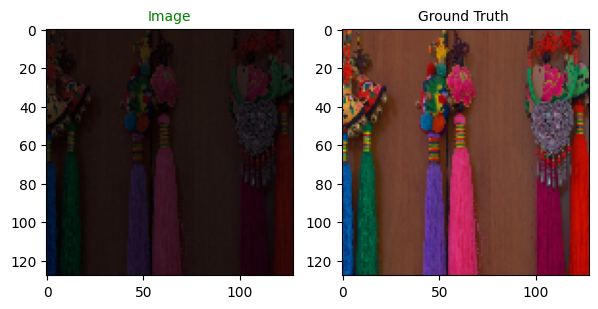

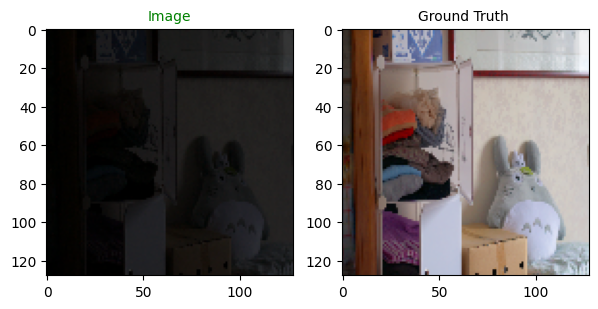

In [6]:
for i in range(0,25,5):
    plot_images(x_test[i].reshape((SIZE, SIZE, 3)),y_test[i].reshape((SIZE, SIZE, 3)))

In [7]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, image_channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Conv2d(1, 1, kernel_size=13, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        x = x.squeeze().unsqueeze(1)
        return x

In [9]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim=100, image_channels=3):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(noise_dim, 512, kernel_size=4, stride=2, padding=1, bias=False)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv1 = nn.Conv2d(32, image_channels, kernel_size=129, stride=1, padding="valid")
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(64)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.deconv1(x)))
        # print(x.shape)
        x = self.relu(self.bn2(self.deconv2(x)))
        # print(x.shape)
        x = self.relu(self.bn3(self.deconv3(x)))
        # print(x.shape)
        x = self.relu(self.conv1(self.deconv4(x)))
        # print(x.shape)
        return x

In [10]:
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load a pre-trained ResNet18 model
resnet18 = models.resnet18(pretrained=True)
# Remove the last fully connected layer to get feature maps
resnet18 = nn.Sequential(
    *list(resnet18.children())[:-1],
    nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
)

# Define a function to preprocess the image and get the 512 size array feature map
"""
# Example usage
image_path = "/content/dog.jpg"
feature_map = get_feature_map(image_path)
print("Shape of the feature map:", feature_map.shape)
"""
def get_feature_map(image):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    # Set the model to evaluation mode
    resnet18.eval()

    # Get the feature map
    with torch.no_grad():
        feature_map = resnet18(input_batch)
    embedding  = feature_map.view(1, 16, 16)

    return embedding


/DATA/sujit_2021cs35/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/DATA/sujit_2021cs35/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return (image, label)

In [12]:
train_images = [torch.tensor(img).float() for img in x_train]
train_labels = [torch.tensor(lbl).float() for lbl in y_train]
train_images = [img.to(device) for img in train_images]
train_labels = [lbl.to(device) for lbl in train_labels]

test_images = [torch.tensor(img).float() for img in x_test]
test_labels = [torch.tensor(lbl).float() for lbl in y_test]
test_images = [img.to(device) for img in test_images]
test_labels = [lbl.to(device) for lbl in test_labels]

In [13]:
train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
import torch.optim as optim
discriminator = Discriminator().to(device)
generator = Generator(noise_dim = 1).to(device)
criterion1 = nn.BCELoss()
criterion2 = nn.MSELoss()

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [15]:
def get_batch_embeddings(img_batch):
  arr = np.empty((0, 1, 16, 16))
  for image in img_batch:
    image = image.permute(1,2,0)
    ebd = get_feature_map(image.cpu().numpy().astype('uint8')).unsqueeze(0)
    arr = np.vstack((arr, ebd))
  return torch.tensor(arr)

In [16]:
def train_gan(num_epochs):
    for epoch in range(num_epochs):
        for i, (image, label) in enumerate(train_dataloader):
            image.to(device)
            label.to(device)
            batch_size=image.shape[0]
            one_labels = torch.ones(batch_size, 1).to(device)
            zero_labels = torch.zeros(batch_size, 1).to(device)
            
            # Train Discriminator
            # Loss 1: Real images
            real_outputs = discriminator(label)
            d_loss_light = criterion1(real_outputs, one_labels)
            
            # Loss 2: Fake images
            noise = get_batch_embeddings(image).to(device).float()
            generator.eval()
            with torch.no_grad():
                fake_images = generator(noise).astype('uint8')
            fake_outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion1(fake_outputs, zero_labels)
            
            d_loss = d_loss_light + d_loss_fake
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            generator.train()
            generated_images = generator(noise).astype('uint8')
            discriminator.eval()
            outputs = discriminator(generated_images)
            g_loss = criterion1(outputs, one_labels)
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            if epoch % 5 and i % 10 == 0:
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_dataloader)}], '
                      f'Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}')

In [ ]:
# Train GAN
num_epochs = 50
train_gan(num_epochs)

In [ ]:
# save model weights
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
print("All weights saved!")

In [17]:
# load model weights
generator.load_state_dict(torch.load('generator.pth'))
discriminator.load_state_dict(torch.load('discriminator.pth'))

<All keys matched successfully>

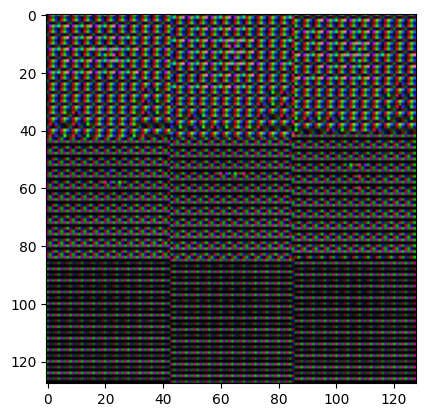

In [24]:
# view images from generator
noise = torch.randn(1, 1, 16, 16).to(device)
fake_images = generator(noise)
fake_images = fake_images.cpu().detach().numpy().squeeze().astype('uint8')
fake_images = fake_images.reshape((128, 128, 3))
plt.imshow(fake_images)
plt.show()

In [ ]:
import numpy as np
for i, (image, label) in enumerate(test_dataloader):
    # display the images
    # for img in image:
    #     plt.imshow(img.cpu().reshape((128, 128, 3)))
    #     plt.show()
    image.to(device)
    label.to(device)
    batch_size=image.shape[0]
    noise = get_batch_embeddings(image).to(device).float()
    generator.eval()
    with torch.no_grad():
        fake_images = generator(noise)
    
    # view images from generator
    fake_images = fake_images.cpu().detach().numpy().reshape((batch_size, 128, 128, 3)).astype('uint8')
    real_images = image.cpu().detach().numpy().reshape(batch_size, 128, 128, 3)
    
    # show some real-fake image pairs
    for i in range(5):
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(real_images[i])
        ax[1].imshow(fake_images[i])
        plt.show()
        plt.close()

Classical methods: https://www.sciencedirect.com/science/article/pii/S2405844023017656

https://medium.com/@pratikpophali113/low-light-image-enhancement-using-deep-retinex-net-model-dec7b82a85e8

https://github.com/Pratik3194/Low_light_image_enhancement/blob/main/Low_light_image_enhancement.ipynb

https://github.com/weichen582/RetinexNet

https://medium.com/htx-s-s-coe/breaking-through-the-darkness-how-to-enhance-low-light-images-with-deep-learning-techniques-257c98daf96f

Loss functions: https://arxiv.org/pdf/1511.08861.pdf